## Feature Selection and Engineering

- Code in this notebook: 
    - Loads and cleans MLB pitch data from the 2015 - 2018 seasons. Datasets can be found on Kaggle [here](https://www.kaggle.com/pschale/mlb-pitch-data-20152018#games.csv).
    - Performs feature engineering and creates a new master dataframe with selected features.
    - Tests different combinations of features and performs model performance baselining using logistic regression. 

### Imports

In [349]:
%pylab inline

from collections import OrderedDict

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

Populating the interactive namespace from numpy and matplotlib


### Load "atbats" Dataset

In [227]:
# Load first 300000 rows as a subset for exploratory data analysis
df_batting_subset = pd.read_csv('data/atbats.csv', nrows=300000)

In [228]:
# View number of rows and columns in dataframe
df_batting_subset.shape

(300000, 11)

#### Selected Field Name Descriptions

**ab_id:** at-bat ID. First 4 digits are year. Matches with ab_id in pitches.csv

**batter_id:** player ID of the batter. Given by MLB, player names found in player_names.csv

**event:** description of the result of the at-bat

**g_id:** game ID. First 4 digits are year

**inning:** inning number

**o:** number of outs after this at-bat

**p_score:** score for the pitcher's team

**p_throws:** which hand pitcher throws with. Single character, R or L

**pitcher_id:** player ID of the pitcher. Given by MLB, player names found in player_names.csv

**stand:** which side batter hits on. Single character, R or L

### Load "pitches" Dataset

In [229]:
# Load first 300000 rows as a subset for exploratory data analysis
df_pitches_subset = pd.read_csv('data/pitches.csv', nrows=300000)

In [230]:
# View number of rows and columns in dataframe
df_pitches_subset.shape

(300000, 40)

#### Selected Field Name Descriptions

**code**: Records the result of the pitch. See dataset description for list of codes and their meaning

**type**: Simplified code, S (strike) B (ball) or X (in play)

**pitch_type**: Type of pitch. See dataset description for list of pitch types

**b_score**: score for the batter's team

**ab_id**: at-bat ID. Matches up with atbats.csv

**b_count**: balls in the current count

**s_count**: strikes in the current count

**outs**: number of outs (before pitch is thrown)

**pitch_num**: pitch number (of at-bat)

**on_1b**: True if there's a runner on first, False if empty

**on_2b**: True if there's a runner on second, False if empty

**on_3b**: True if there's a runner on third, False if empty

#### Pitch Code Descriptions

**B** - Ball ("*B" indicates ball in dirt)

**S** - Swinging Strike

**C** - Called Strike

**F** - Foul

**T** - Foul Tip

**L** - Foul Bunt

**I** - Intentional Ball

**W** - Swinging Strike (Blocked)

**M** - Missed Bunt

**P** - Pitchout

**Q** - Swinging pitchout

**R** - Foul pitchout

**X** - In play, out(s)

**D** - In play, no out

**E** - In play, runs

**H** - Hit by pitch

In [9]:
# Target column = code
# Code = Result of the pitch 

# Display counts of result of pitches
df_pitches_subset['code'].value_counts()

B     33300
C     17638
F     16770
X     12209
S      8680
D      4211
E      2219
*B     2180
T       790
W       766
I       545
L       350
H       230
M        85
P        26
V         1
Name: code, dtype: int64

### Load "games" Dataset

In [231]:
# Load first 300000 rows as a subset for exploratory data analysis
df_games_subset = pd.read_csv('data/games.csv', nrows=300000)

In [232]:
# View number of rows and columns in dataframe
df_games_subset.shape

(9718, 17)

#### Selected Field Name Descriptions

**away_final_score:** final score for the visiting team

**away_team:** three letter abbreviation for away team; third letter often indicates league(national vs american)

**date:** date of game

**g_id:** game ID. Matches with game_id in atbats.csv

**home_final_score:** final score for the home team

**home_team:** three letter abbreviation for home team; third letter often indicates league(national vs american)

**start_time:** start time of game

### Merge Datasets

In [233]:
# Merge "pitches" and "atbats"
df_pitches_batting_subset = df_pitches_subset.merge(df_batting_subset, on='ab_id')

In [235]:
# Merge "games" and "df_pitches_batting_subset"
df_pitches_batting_games_subset = df_pitches_batting_subset.merge(df_games_subset, on='g_id')

In [236]:
# View number of rows and columns in dataframe
df_pitches_batting_games_subset.shape

(300000, 66)

### Create and Clean Target

In [237]:
# Create new copy of dataframe subset
df_pitches_batting_games_target_subset = df_pitches_batting_games_subset.copy()

In [238]:
# Function to create target value based on code of pitch
# Codes of interest: B (Ball), *B (Ball in dirt), C (Called Strike)
def pitch_code(column):
    if column['code'] == 'C':
        val = 1
    elif column['code'] == 'B' or column['code'] == '*B':
        val = 0
    else: 
        val = np.nan
    return val

In [239]:
# Apply function to create target column
df_pitches_batting_games_target_subset['pitch_target'] = df_pitches_batting_games_target_subset.apply(pitch_code, axis=1)

In [240]:
# View number of rows and columns in dataframe
df_pitches_batting_games_target_subset.shape

(300000, 67)

In [241]:
# Drop NA values
df_pitches_batting_games_target_subset.dropna(inplace=True)

In [242]:
# Reset index
df_pitches_batting_games_target_subset.reset_index(drop=True, inplace=True)

In [243]:
# Cast target values to integer
df_pitches_batting_games_target_subset['pitch_target'] = df_pitches_batting_games_target_subset['pitch_target'].astype(int)

### Additional Data Cleaning

In [245]:
# Drop rows with 2 strikes already in the count
df_pitches_batting_games_target_subset.drop(
    df_pitches_batting_games_target_subset[df_pitches_batting_games_target_subset.s_count == 2].index, inplace=True)

In [248]:
# Drop rows with 4 balls already in the count
df_pitches_batting_games_target_subset.drop(
    df_pitches_batting_games_target_subset[df_pitches_batting_games_target_subset.b_count == 4].index, inplace=True)

In [249]:
# View number of rows and columns in dataframe
df_pitches_batting_games_target_subset.shape

(124392, 67)

In [251]:
# View values for pitch_type field
df_pitches_batting_games_target_subset.pitch_type.value_counts()

FF    45044
FT    16070
SL    15977
SI    13999
CH    11697
CU     9468
FC     6872
KC     2966
FS     1388
KN      800
EP       84
FO       20
UN        3
SC        3
FA        1
Name: pitch_type, dtype: int64

In [252]:
# Remove FA (Not Defined)
df_pitches_batting_games_target_subset.drop(
    df_pitches_batting_games_target_subset[df_pitches_batting_games_target_subset.pitch_type == 'FA'].index, inplace=True)


In [253]:
# Remove SC (Not Defined)
df_pitches_batting_games_target_subset.drop(
    df_pitches_batting_games_target_subset[df_pitches_batting_games_target_subset.pitch_type == 'SC'].index, inplace=True)


In [254]:
# Remove UN (Unknown)
df_pitches_batting_games_target_subset.drop(
    df_pitches_batting_games_target_subset[df_pitches_batting_games_target_subset.pitch_type == 'UN'].index, inplace=True)


In [255]:
# Remove FO (Pitchout)
df_pitches_batting_games_target_subset.drop(
    df_pitches_batting_games_target_subset[df_pitches_batting_games_target_subset.pitch_type == 'FO'].index, inplace=True)


In [256]:
# Remove EP (Eephus)
df_pitches_batting_games_target_subset.drop(
    df_pitches_batting_games_target_subset[df_pitches_batting_games_target_subset.pitch_type == 'EP'].index, inplace=True)


In [257]:
# Remove PO (Pitchout)
df_pitches_batting_games_target_subset.drop(
    df_pitches_batting_games_target_subset[df_pitches_batting_games_target_subset.pitch_type == 'PO'].index, inplace=True)


In [258]:
# Remove IN (Intentional Ball)
df_pitches_batting_games_target_subset.drop(
    df_pitches_batting_games_target_subset[df_pitches_batting_games_target_subset.pitch_type == 'IN'].index, inplace=True)


In [259]:
# View number of rows and columns in dataframe
df_pitches_batting_games_target_subset.shape

(124281, 67)

### Feature Engineering

In [260]:
# Create dataframe to add new feature
df_master_1 = df_pitches_batting_games_target_subset

In [261]:
# Create "fatigue factor" feature: cumulative pitch count for a pitcher in each game
df_master_1['pitch_count'] = df_pitches_batting_games_target_subset.groupby(['g_id', 'pitcher_id'], as_index=False).cumcount()+1


In [263]:
# Drop "pitch_num" feature: pitch number of individual at-bats
df_master_1 = df_master_1.drop('pitch_num', axis = 1)

In [264]:
# View number of rows and columns in dataframe
df_master_1.shape

(124281, 67)

In [265]:
# Create dataframe to add new feature
df_master_2 = df_master_1

In [266]:
# Create "strike + ball count" feature: combination of "Strike(s)" and "Ball(s)" features
df_master_2['s_b_count'] = (df_master_1.s_count.map(str) + ' Strike(s) ' + df_master_1.b_count.map(str)) + ' Ball(s)'

In [268]:
# View value counts for strike + ball feature
df_master_2.s_b_count.value_counts()

0.0 Strike(s) 0.0 Ball(s)    55805
1.0 Strike(s) 0.0 Ball(s)    20096
0.0 Strike(s) 1.0 Ball(s)    17352
1.0 Strike(s) 1.0 Ball(s)    13759
1.0 Strike(s) 2.0 Ball(s)     6194
0.0 Strike(s) 2.0 Ball(s)     5637
0.0 Strike(s) 3.0 Ball(s)     2730
1.0 Strike(s) 3.0 Ball(s)     2708
Name: s_b_count, dtype: int64

In [269]:
# Dummify variables
df_master_2 = pd.get_dummies(df_master_2, prefix=['s_b_count'], columns=['s_b_count'])

In [270]:
# View number of rows and columns in dataframe
df_master_2.shape

(124281, 75)

In [271]:
# Create dataframe to add new feature
df_master_3 = df_master_2

In [272]:
# Create "runners on base" feature: combination of "on_1b", "on_2b" and "on_3b" features
df_master_3['runners_on_base'] = (df_master_2.on_1b.map(str) + ' 1st Base ' + df_master_2.on_2b.map(str) + ' 2nd Base ' + df_master_2.on_3b.map(str) + ' 3rd Base')

In [274]:
# View value counts for runners on base feature
df_master_3.runners_on_base.value_counts()

0.0 1st Base 0.0 2nd Base 0.0 3rd Base    73858
1.0 1st Base 0.0 2nd Base 0.0 3rd Base    22624
0.0 1st Base 1.0 2nd Base 0.0 3rd Base     9045
1.0 1st Base 1.0 2nd Base 0.0 3rd Base     8020
1.0 1st Base 0.0 2nd Base 1.0 3rd Base     3457
0.0 1st Base 0.0 2nd Base 1.0 3rd Base     2906
1.0 1st Base 1.0 2nd Base 1.0 3rd Base     2502
0.0 1st Base 1.0 2nd Base 1.0 3rd Base     1869
Name: runners_on_base, dtype: int64

In [275]:
# Dummify variables
df_master_3 = pd.get_dummies(df_master_3, prefix=['runners_on_base'], columns=['runners_on_base'])

In [276]:
# View number of rows and columns in dataframe
df_master_3.shape

(124281, 83)

In [277]:
# Create dataframe to add new feature
df_master_4 = df_master_3

In [278]:
# Dummify variables for "pitch type" feature
df_master_4 = pd.get_dummies(df_master_4, prefix=['pitch_type'], columns=['pitch_type'], drop_first=True)

In [279]:
# View number of rows and columns in dataframe
df_master_4.shape

(124281, 91)

In [280]:
# Create dataframe to add new feature
df_master_5 = df_master_4

In [281]:
# Create "pitcher hitter position" feature: combination of "p_throws" and "stand" features
df_master_5['pitcher_hitter_position'] = (df_master_4.p_throws.map(str) + ' -Pitcher ' + df_master_4.stand.map(str) + ' -Hitter')

In [283]:
# View value counts for pitcher hitter position feature
df_master_5.pitcher_hitter_position.value_counts()

R -Pitcher R -Hitter    47093
R -Pitcher L -Hitter    45451
L -Pitcher R -Hitter    21813
L -Pitcher L -Hitter     9924
Name: pitcher_hitter_position, dtype: int64

In [284]:
# Dummify variables for "pitcher hitter position" feature
df_master_5 = pd.get_dummies(df_master_5, prefix=['pitcher_hitter_position'], columns=['pitcher_hitter_position'])

In [285]:
# View number of rows and columns in dataframe
df_master_5.shape

(124281, 95)

In [286]:
# View all column names
df_master_5.columns

Index(['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir',
       'break_angle', 'break_length', 'break_y', 'ax', 'ay', 'az', 'sz_bot',
       'sz_top', 'type_confidence', 'vx0', 'vy0', 'vz0', 'x', 'x0', 'y', 'y0',
       'z0', 'pfx_x', 'pfx_z', 'nasty', 'zone', 'code', 'type', 'event_num',
       'b_score', 'ab_id', 'b_count', 's_count', 'outs', 'on_1b', 'on_2b',
       'on_3b', 'batter_id', 'event', 'g_id', 'inning', 'o', 'p_score',
       'p_throws', 'pitcher_id', 'stand', 'top', 'attendance',
       'away_final_score', 'away_team', 'date', 'elapsed_time',
       'home_final_score', 'home_team', 'start_time', 'umpire_1B', 'umpire_2B',
       'umpire_3B', 'umpire_HP', 'venue_name', 'weather', 'wind', 'delay',
       'pitch_target', 'pitch_count', 's_b_count_0.0 Strike(s) 0.0 Ball(s)',
       's_b_count_0.0 Strike(s) 1.0 Ball(s)',
       's_b_count_0.0 Strike(s) 2.0 Ball(s)',
       's_b_count_0.0 Strike(s) 3.0 Ball(s)',
       's_b_count_1.0 Strike(s) 0.0 Ball(s)',
     

### Create, Save and Load Master Dataframe

In [287]:
# Create master dataframe
df_master = df_master_5

In [295]:
# Save dataframe as a csv file
df_master.to_csv('df_master.csv')

In [65]:
# Convenience code to read in master dataframe
# df_master = pd.read_csv('df_master.csv')

In [66]:
# Delete unnecessary column
df_master = df_master.drop('Unnamed: 0', axis = 1)

In [67]:
# View number of rows and columns in dataframe
df_master.shape

(124281, 92)

### Exploratory Data Analysis

0    0.616241
1    0.383759
Name: pitch_target, dtype: float64


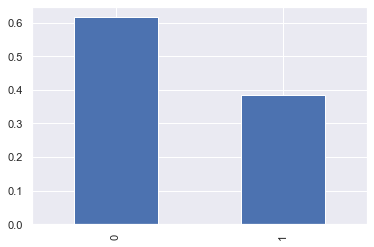

In [288]:
# Plot distribution of target (1 = ball, 0 = strike)
target_pcts = df_master.pitch_target.value_counts(normalize=True) 
print(target_pcts)

target_pcts.plot(kind='bar')

In [289]:
# Create copy of master dataframe for feature testing
df_pitches_batting_games_target_initial_feature_subset = \
    df_master.copy()

In [290]:
# View summary statistics
df_pitches_batting_games_target_initial_feature_subset.describe()

,px,pz,start_speed,end_speed,spin_rate,spin_dir,break_angle,break_length,break_y,ax,...,pitch_type_FS,pitch_type_FT,pitch_type_KC,pitch_type_KN,pitch_type_SI,pitch_type_SL,pitcher_hitter_position_L -Pitcher L -Hitter,pitcher_hitter_position_L -Pitcher R -Hitter,pitcher_hitter_position_R -Pitcher L -Hitter,pitcher_hitter_position_R -Pitcher R -Hitter
count,124281.000000,124281.000000,124281.000000,124281.000000,124281.000000,124281.000000,124281.000000,124281.000000,124281.000000,124281.000000,...,124281.000000,124281.000000,124281.000000,124281.000000,124281.000000,124281.000000,124281.000000,124281.000000,124281.000000,124281.000000
mean,-0.040460,2.222532,87.936157,81.089480,1778.958402,180.360449,5.262691,6.501205,23.799389,-2.095688,...,0.011168,0.129304,0.023865,0.006437,0.112640,0.128555,0.079851,0.175514,0.365712,0.378924
std,0.977935,0.977094,5.894223,5.253628,651.724839,66.436502,24.422461,2.898766,0.068637,10.861284,...,0.105089,0.335537,0.152630,0.079973,0.316153,0.334709,0.271064,0.380407,0.481631,0.485121
min,-8.291000,-3.460000,47.300000,43.800000,2.376000,-0.002000,-85.800000,0.400000,23.500000,-31.298000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.788000,1.554000,84.200000,77.900000,1351.983000,137.794000,-12.800000,4.300000,23.800000,-11.173000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.014000,2.199000,89.400000,82.300000,1892.596000,196.240000,7.900000,5.900000,23.800000,-3.540000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.711000,2.886000,92.400000,85.000000,2260.295000,224.872000,26.300000,7.900000,23.800000,6.465000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,4.197000,7.180000,102.800000,94.900000,4829.975000,359.971000,104.400000,24.600000,24.200000,39.369000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Feature Testing and Model Baselining

In [291]:
# Test 's_count' feature
df_feature0 = \
    df_pitches_batting_games_target_initial_feature_subset \
    [['s_count', 'pitch_target']]

In [292]:
# Define features and targets
x = df_feature0.drop(['pitch_target'], axis=1)
y = df_feature0['pitch_target']

In [293]:
# Function to split data and score on selected metrics
def split_score(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)
    
    print('\nAccuracy score is:', accuracy_score(lr.predict(x_test), y_test))
    print('\nF1 score is:', f1_score(lr.predict(x_test), y_test))
    print('\nPrecision score is:', precision_score(y_test, lr.predict(x_test)))
    print('\nRecall score is:', recall_score(y_test, lr.predict(x_test)))
    print('\nCoefficient scores: ', lr.coef_)
    print('\nConfusion matrix:', confusion_matrix(y_test, lr.predict(x_test)))

split_score(x, y)


Accuracy score is: 0.5538882407370157

F1 score is: 0.5681012658227849

Precision score is: 0.45046324891908585

Recall score is: 0.7688982604111756

Coefficient scores:  [[-0.93282334]]

Confusion matrix: [[6475 8897]
 [2192 7293]]


In [297]:
# Test 's_b_count' feature
df_feature1 = \
    df_pitches_batting_games_target_initial_feature_subset \
    [['s_b_count_0.0 Strike(s) 1.0 Ball(s)',
       's_b_count_0.0 Strike(s) 2.0 Ball(s)',
       's_b_count_0.0 Strike(s) 3.0 Ball(s)',
       's_b_count_1.0 Strike(s) 0.0 Ball(s)',
       's_b_count_1.0 Strike(s) 1.0 Ball(s)',
       's_b_count_1.0 Strike(s) 2.0 Ball(s)',
       's_b_count_1.0 Strike(s) 3.0 Ball(s)', 'pitch_target']]

In [298]:
# Define features and targets
x = df_feature1.drop(['pitch_target'], axis=1)
y = df_feature1['pitch_target']

In [299]:
# Function to split data and score on selected metrics
def split_score(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)
    
    print('\nAccuracy score is:', accuracy_score(lr.predict(x_test), y_test))
    print('\nF1 score is:', f1_score(lr.predict(x_test), y_test))
    print('\nPrecision score is:', precision_score(y_test, lr.predict(x_test)))
    print('\nRecall score is:', recall_score(y_test, lr.predict(x_test)))
    print('\nCoefficient scores: ', lr.coef_)
    print('\nConfusion matrix:', confusion_matrix(y_test, lr.predict(x_test)))

split_score(x, y)


Accuracy score is: 0.5538882407370157

F1 score is: 0.5681012658227849

Precision score is: 0.45046324891908585

Recall score is: 0.7688982604111756

Coefficient scores:  [[-0.19713584  0.00555368  0.76938261 -1.1484872  -0.93527878 -0.6952582
  -0.31776832]]

Confusion matrix: [[6475 8897]
 [2192 7293]]


In [302]:
# Test 's_b_count' and 'outs' features
df_feature2 = \
    df_pitches_batting_games_target_initial_feature_subset \
    [['s_b_count_0.0 Strike(s) 1.0 Ball(s)',
       's_b_count_0.0 Strike(s) 2.0 Ball(s)',
       's_b_count_0.0 Strike(s) 3.0 Ball(s)',
       's_b_count_1.0 Strike(s) 0.0 Ball(s)',
       's_b_count_1.0 Strike(s) 1.0 Ball(s)',
       's_b_count_1.0 Strike(s) 2.0 Ball(s)',
       's_b_count_1.0 Strike(s) 3.0 Ball(s)', 'outs', 'pitch_target']]

In [303]:
# Define features and targets
x = df_feature2.drop(['pitch_target'], axis=1)
y = df_feature2['pitch_target']

In [304]:
# Function to split data and score on selected metrics
def split_score(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)
    
    print('\nAccuracy score is:', accuracy_score(lr.predict(x_test), y_test))
    print('\nF1 score is:', f1_score(lr.predict(x_test), y_test))
    print('\nPrecision score is:', precision_score(y_test, lr.predict(x_test)))
    print('\nRecall score is:', recall_score(y_test, lr.predict(x_test)))
    print('\nCoefficient scores: ', lr.coef_)
    print('\nConfusion matrix:', confusion_matrix(y_test, lr.predict(x_test)))

split_score(x, y)


Accuracy score is: 0.5527215673653297

F1 score is: 0.5698034360006191

Precision score is: 0.4500886362247081

Recall score is: 0.7762783342119135

Coefficient scores:  [[-0.19444802  0.01088326  0.77664846 -1.1487229  -0.9333761  -0.6900412
  -0.31044458 -0.08326777]]

Confusion matrix: [[6376 8996]
 [2122 7363]]


In [306]:
# Test 's_b_count', 'outs' and 'pitch_count' features
df_feature3 = \
    df_pitches_batting_games_target_initial_feature_subset \
    [['s_b_count_0.0 Strike(s) 1.0 Ball(s)',
       's_b_count_0.0 Strike(s) 2.0 Ball(s)',
       's_b_count_0.0 Strike(s) 3.0 Ball(s)',
       's_b_count_1.0 Strike(s) 0.0 Ball(s)',
       's_b_count_1.0 Strike(s) 1.0 Ball(s)',
       's_b_count_1.0 Strike(s) 2.0 Ball(s)',
       's_b_count_1.0 Strike(s) 3.0 Ball(s)', 'outs', 'pitch_count', 'pitch_target']]

In [307]:
# Define features and targets
x = df_feature3.drop(['pitch_target'], axis=1)
y = df_feature3['pitch_target']

In [308]:
# Function to split data and score on selected metrics
def split_score(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)
    
    print('\nAccuracy score is:', accuracy_score(lr.predict(x_test), y_test))
    print('\nF1 score is:', f1_score(lr.predict(x_test), y_test))
    print('\nPrecision score is:', precision_score(y_test, lr.predict(x_test)))
    print('\nRecall score is:', recall_score(y_test, lr.predict(x_test)))
    print('\nCoefficient scores: ', lr.coef_)
    print('\nConfusion matrix:', confusion_matrix(y_test, lr.predict(x_test)))

split_score(x, y)


Accuracy score is: 0.5532043287605101

F1 score is: 0.568397326286336

Precision score is: 0.4501138671754786

Recall score is: 0.7710068529256721

Coefficient scores:  [[-0.19189526  0.01527536  0.78228304 -1.14764335 -0.93023854 -0.68527798
  -0.30244964 -0.08039172 -0.0023476 ]]

Confusion matrix: [[6438 8934]
 [2172 7313]]


In [310]:
# Test 's_b_count', 'outs', 'pitch_count' and 'runners_on_base' features
df_feature4 = \
    df_pitches_batting_games_target_initial_feature_subset \
    [['s_b_count_0.0 Strike(s) 1.0 Ball(s)',
       's_b_count_0.0 Strike(s) 2.0 Ball(s)',
       's_b_count_0.0 Strike(s) 3.0 Ball(s)',
       's_b_count_1.0 Strike(s) 0.0 Ball(s)',
       's_b_count_1.0 Strike(s) 1.0 Ball(s)',
       's_b_count_1.0 Strike(s) 2.0 Ball(s)',
       's_b_count_1.0 Strike(s) 3.0 Ball(s)', 'outs', 'pitch_count', 'runners_on_base_0.0 1st Base 0.0 2nd Base 0.0 3rd Base',
       'runners_on_base_0.0 1st Base 0.0 2nd Base 1.0 3rd Base',
       'runners_on_base_0.0 1st Base 1.0 2nd Base 0.0 3rd Base',
       'runners_on_base_0.0 1st Base 1.0 2nd Base 1.0 3rd Base',
       'runners_on_base_1.0 1st Base 0.0 2nd Base 0.0 3rd Base',
       'runners_on_base_1.0 1st Base 0.0 2nd Base 1.0 3rd Base',
       'runners_on_base_1.0 1st Base 1.0 2nd Base 0.0 3rd Base',
       'runners_on_base_1.0 1st Base 1.0 2nd Base 1.0 3rd Base', 'pitch_target']]

In [311]:
# Define features and targets
x = df_feature4.drop(['pitch_target'], axis=1)
y = df_feature4['pitch_target']

In [312]:
# Function to split data and score on selected metrics
def split_score(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)
    
    print('\nAccuracy score is:', accuracy_score(lr.predict(x_test), y_test))
    print('\nF1 score is:', f1_score(lr.predict(x_test), y_test))
    print('\nPrecision score is:', precision_score(y_test, lr.predict(x_test)))
    print('\nRecall score is:', recall_score(y_test, lr.predict(x_test)))
    print('\nCoefficient scores: ', lr.coef_)
    print('\nConfusion matrix:', confusion_matrix(y_test, lr.predict(x_test)))

split_score(x, y)


Accuracy score is: 0.5704228185219455

F1 score is: 0.5607207503702485

Precision score is: 0.45975848343790054

Recall score is: 0.7185028993147075

Coefficient scores:  [[-0.18313562  0.02879107  0.80462679 -1.15668972 -0.9304808  -0.68015667
  -0.28896326 -0.03290086 -0.00217302  0.33506713 -0.08148589  0.01449642
  -0.25764495  0.09495746 -0.05878669  0.05781634  0.04659314]]

Confusion matrix: [[7364 8008]
 [2670 6815]]


In [314]:
# Test 's_b_count', 'outs', 'pitch_count', 'runners_on_base' and 'p_score' features
df_feature5 = \
    df_pitches_batting_games_target_initial_feature_subset \
    [['s_b_count_0.0 Strike(s) 1.0 Ball(s)',
       's_b_count_0.0 Strike(s) 2.0 Ball(s)',
       's_b_count_0.0 Strike(s) 3.0 Ball(s)',
       's_b_count_1.0 Strike(s) 0.0 Ball(s)',
       's_b_count_1.0 Strike(s) 1.0 Ball(s)',
       's_b_count_1.0 Strike(s) 2.0 Ball(s)',
       's_b_count_1.0 Strike(s) 3.0 Ball(s)', 'outs', 'pitch_count', 'runners_on_base_0.0 1st Base 0.0 2nd Base 0.0 3rd Base',
       'runners_on_base_0.0 1st Base 0.0 2nd Base 1.0 3rd Base',
       'runners_on_base_0.0 1st Base 1.0 2nd Base 0.0 3rd Base',
       'runners_on_base_0.0 1st Base 1.0 2nd Base 1.0 3rd Base',
       'runners_on_base_1.0 1st Base 0.0 2nd Base 0.0 3rd Base',
       'runners_on_base_1.0 1st Base 0.0 2nd Base 1.0 3rd Base',
       'runners_on_base_1.0 1st Base 1.0 2nd Base 0.0 3rd Base',
       'runners_on_base_1.0 1st Base 1.0 2nd Base 1.0 3rd Base', 'p_score', 'pitch_target']]

In [315]:
# Define features and targets
x = df_feature5.drop(['pitch_target'], axis=1)
y = df_feature5['pitch_target']

In [316]:
# Function to split data and score on selected metrics
def split_score(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)
    
    print('\nAccuracy score is:', accuracy_score(lr.predict(x_test), y_test))
    print('\nF1 score is:', f1_score(lr.predict(x_test), y_test))
    print('\nPrecision score is:', precision_score(y_test, lr.predict(x_test)))
    print('\nRecall score is:', recall_score(y_test, lr.predict(x_test)))
    print('\nCoefficient scores: ', lr.coef_)
    print('\nConfusion matrix:', confusion_matrix(y_test, lr.predict(x_test)))

split_score(x, y)


Accuracy score is: 0.5707848895683308

F1 score is: 0.5612895267075126

Precision score is: 0.4600916812727518

Recall score is: 0.7195571955719557

Coefficient scores:  [[-0.18433405  0.02875731  0.80797291 -1.15811322 -0.93148523 -0.68048191
  -0.29550776 -0.03322775 -0.00219168  0.33342678 -0.0829757   0.01386839
  -0.2508521   0.09396226 -0.05992379  0.05731254  0.04411374  0.0024083 ]]

Confusion matrix: [[7363 8009]
 [2660 6825]]


In [318]:
# Test 's_b_count', 'outs', 'pitch_count', 'runners_on_base', 'p_score' and 'pitch_type' features
df_feature6 = \
    df_pitches_batting_games_target_initial_feature_subset \
    [['s_b_count_0.0 Strike(s) 1.0 Ball(s)',
       's_b_count_0.0 Strike(s) 2.0 Ball(s)',
       's_b_count_0.0 Strike(s) 3.0 Ball(s)',
       's_b_count_1.0 Strike(s) 0.0 Ball(s)',
       's_b_count_1.0 Strike(s) 1.0 Ball(s)',
       's_b_count_1.0 Strike(s) 2.0 Ball(s)',
       's_b_count_1.0 Strike(s) 3.0 Ball(s)', 'outs', 'pitch_count', 'runners_on_base_0.0 1st Base 0.0 2nd Base 0.0 3rd Base',
       'runners_on_base_0.0 1st Base 0.0 2nd Base 1.0 3rd Base',
       'runners_on_base_0.0 1st Base 1.0 2nd Base 0.0 3rd Base',
       'runners_on_base_0.0 1st Base 1.0 2nd Base 1.0 3rd Base',
       'runners_on_base_1.0 1st Base 0.0 2nd Base 0.0 3rd Base',
       'runners_on_base_1.0 1st Base 0.0 2nd Base 1.0 3rd Base',
       'runners_on_base_1.0 1st Base 1.0 2nd Base 0.0 3rd Base',
       'runners_on_base_1.0 1st Base 1.0 2nd Base 1.0 3rd Base', 'p_score', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS',
       'pitch_type_FT', 'pitch_type_KC', 'pitch_type_KN', 'pitch_type_SI',
       'pitch_type_SL', 'pitch_target']]

In [319]:
# Define features and targets
x = df_feature6.drop(['pitch_target'], axis=1)
y = df_feature6['pitch_target']

In [320]:
# Function to split data and score on selected metrics
def split_score(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)
    
    print('\nAccuracy score is:', accuracy_score(lr.predict(x_test), y_test))
    print('\nF1 score is:', f1_score(lr.predict(x_test), y_test))
    print('\nPrecision score is:', precision_score(y_test, lr.predict(x_test)))
    print('\nRecall score is:', recall_score(y_test, lr.predict(x_test)))
    print('\nCoefficient scores: ', lr.coef_)
    print('\nConfusion matrix:', confusion_matrix(y_test, lr.predict(x_test)))

split_score(x, y)


Accuracy score is: 0.5782676911936275

F1 score is: 0.5580709076345853

Precision score is: 0.4649480191064906

Recall score is: 0.697838692672641

Coefficient scores:  [[-1.52519666e-01  4.79885967e-02  7.73432254e-01 -1.14166874e+00
  -9.09089674e-01 -6.69018437e-01 -2.58792326e-01 -3.33522249e-02
  -1.32615068e-03  2.81308846e-01 -1.24772800e-01 -3.51437001e-02
  -3.21611874e-01  4.68373803e-02 -1.04098119e-01  8.10148398e-03
  -2.29445085e-02  8.58685083e-04  5.82807705e-01  4.01060223e-01
   5.14215883e-01  1.37490623e-01  3.81843035e-01  6.04020047e-01
   1.74878776e-01  5.21221354e-01  5.56865866e-01]]

Confusion matrix: [[7755 7617]
 [2866 6619]]


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [352]:
# Test 's_b_count', 'outs', 'pitch_count', 'runners_on_base', 'p_score', 'pitch_type' and 'pitcher_batter_position' features
df_feature7 = \
    df_pitches_batting_games_target_initial_feature_subset \
    [['s_b_count_0.0 Strike(s) 1.0 Ball(s)',
       's_b_count_0.0 Strike(s) 2.0 Ball(s)',
       's_b_count_0.0 Strike(s) 3.0 Ball(s)',
       's_b_count_1.0 Strike(s) 0.0 Ball(s)',
       's_b_count_1.0 Strike(s) 1.0 Ball(s)',
       's_b_count_1.0 Strike(s) 2.0 Ball(s)',
       's_b_count_1.0 Strike(s) 3.0 Ball(s)', 'outs', 'pitch_count', 'runners_on_base_0.0 1st Base 0.0 2nd Base 0.0 3rd Base',
       'runners_on_base_0.0 1st Base 0.0 2nd Base 1.0 3rd Base',
       'runners_on_base_0.0 1st Base 1.0 2nd Base 0.0 3rd Base',
       'runners_on_base_0.0 1st Base 1.0 2nd Base 1.0 3rd Base',
       'runners_on_base_1.0 1st Base 0.0 2nd Base 0.0 3rd Base',
       'runners_on_base_1.0 1st Base 0.0 2nd Base 1.0 3rd Base',
       'runners_on_base_1.0 1st Base 1.0 2nd Base 0.0 3rd Base',
       'runners_on_base_1.0 1st Base 1.0 2nd Base 1.0 3rd Base', 'p_score', 'pitch_type_CU', 'pitch_type_FC', 'pitch_type_FF', 'pitch_type_FS',
       'pitch_type_FT', 'pitch_type_KC', 'pitch_type_KN', 'pitch_type_SI',
       'pitch_type_SL', 'pitcher_hitter_position_L -Pitcher L -Hitter',
       'pitcher_hitter_position_L -Pitcher R -Hitter',
       'pitcher_hitter_position_R -Pitcher L -Hitter',
       'pitcher_hitter_position_R -Pitcher R -Hitter']]

In [353]:
# Define features and targets
x = df_feature7.drop(['pitch_target'], axis=1)
y = df_feature7['pitch_target']

In [363]:
# Function to split data and score on selected metrics
def split_score(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    lr = LogisticRegression(class_weight='balanced')
    lr.fit(x_train, y_train)
    
    print('\nAccuracy score is:', accuracy_score(lr.predict_proba(x_test)[:,1] > 0.55, y_test))
    print('\nF1 score is:', f1_score(lr.predict_proba(x_test)[:,1] > 0.55, y_test))
    print('\nPrecision score is:', precision_score(y_test, lr.predict_proba(x_test)[:,1] > 0.55))
    print('\nRecall score is:', recall_score(y_test, lr.predict_proba(x_test)[:,1] > 0.55))
    print('\nCoefficient scores: ', lr.coef_)
    print('\nConfusion matrix:', confusion_matrix(y_test, lr.predict_proba(x_test)[:,1] > 0.55))

split_score(x, y)


Accuracy score is: 0.6028885223478296

F1 score is: 0.4398797026612949

Precision score is: 0.47628409928729415

Recall score is: 0.408645229309436

Coefficient scores:  [[ 8.73204329e-02  8.46854885e-02  1.43623277e-01 -6.68590796e-01
  -3.61214932e-01 -1.07077751e-01 -1.31610675e-03 -2.32988363e-01
  -5.48959829e-03  3.54938931e-01 -3.51559185e-02 -7.65998027e-02
  -3.73859327e-02 -1.00165166e-01 -3.81507867e-02 -4.98014330e-02
  -1.79206539e-02  4.99814511e-02  3.78092990e-02 -1.61582956e-02
   1.79659359e-01 -2.04324339e-02 -4.13303538e-02  1.02152851e-02
  -1.22227047e-03  6.96239716e-02  4.99460657e-02  2.50023501e-02
  -9.03616180e-02 -1.06268140e-01  1.71386645e-01 -9.51379198e-02
   1.09892573e-01 -1.07670303e-01 -1.55187326e-03 -9.15217029e-05]]

Confusion matrix: [[11110  4262]
 [ 5609  3876]]


//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
